<a href="https://colab.research.google.com/github/arturtoshev/turbulent_flows_exercises/blob/main/exercise_02_summer22_fft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
########################################################################
#                        LEGAL NOTICE                                  #
# ALL RIGHTS RESERVED TO                                               #
# Authors: Artur Toshev                                                #
# CHAIR OF AERODYNAMICS AND FLUID MECHANICS                            #
# TECHNICAL UNIVERSITY OF MUNICH                                       #
# Written for: TURBULENT FLOWS - EXERCISES                             #
# Published: 11.05.2022                                                #
# Updated:   11.05.2022                                                #
########################################################################
# Code for Exercise 02 - Spectral Analysis                             #
# Fast Fourier Transform (FFT), Energy spectrum                        # 
# VERSION: Summer 2022                                                 #
########################################################################

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib as mpl
# import matplotlib.image as mpimg

plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size':18})

# 1D Temporal FFT

Given: 
Signal in time $u_n, \; n=0,1,...N-1$. In out case the $n=0$ corresponds to $t=0$ and $n=N-1$ to $t=1s$. Thus, the physical signal is sampled with frequency $1/N$.

[FFT](https://numpy.org/doc/stable/reference/routines.fft.html) implements:
$$\hat{u}(w)=\sum_{n=0}^{N-1}u(n) e^{-i 2 \pi (wn/N)}, \qquad w=0,1,...,N-1$$

With Euler's formula:
$$e^{ik}=\cos{(k)}+i\sin{(k)} \Longleftrightarrow e^{-ik}=\cos{(k)}-i\sin{(k)}$$
we obtain the equivalent FFT formulation:
$$\hat{u}(w)=\sum_{n=0}^{N-1}u(n) \left[\cos{(2 \pi wn/N)}-i\sin{(2 \pi wn/N)}\right], \qquad w=0,1,...,N-1$$


If we denote 

$$w_n=e^{-2\pi i /N}=\cos(2 \pi /N) - i \sin(2 \pi /N)$$

then the DFT matrix can be written as (see [Brunton&Kutz 2019](https://www.cambridge.org/core/books/datadriven-science-and-engineering/77D52B171B60A496EAFE4DB662ADC36E) p.58)

$$
\left[\begin{array}{c}
\hat{u}_{0} \\
\hat{u}_{1} \\
\hat{u}_{2} \\
\vdots \\
\hat{u}_{N-1}
\end{array}\right]=\left[\begin{array}{ccccc}
1 & 1 & 1 & \cdots & 1 \\
1 & \omega_{N} & \omega_{N}^{2} & \cdots & \omega_{N}^{N-1} \\
1 & \omega_{N}^{2} & \omega_{N}^{4} & \cdots & \omega_{N}^{2(N-1)} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & \omega_{N}^{N-1} & \omega_{N}^{2(N-1)} & \cdots & \omega_{N}^{(N-1)^{2}}
\end{array}\right]\left[\begin{array}{c}
u_{0} \\
u_{1} \\
u_{1} \\
\vdots \\
u_{N-1}
\end{array}\right].
$$

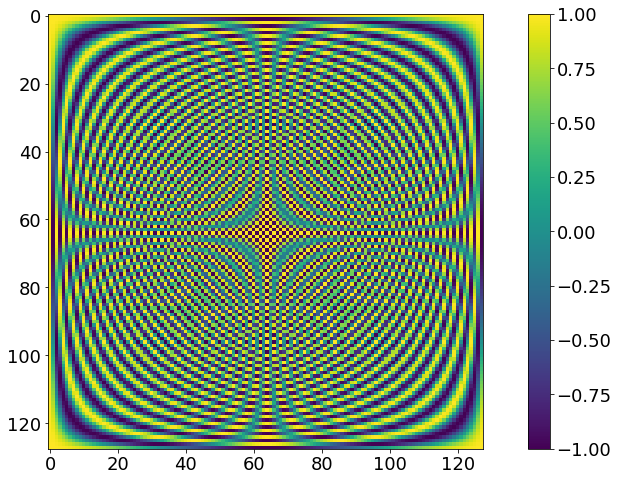

In [ ]:
m = 128
M = np.zeros((m, m), dtype=complex)
w_N = complex(np.cos(2*np.pi / m), -np.sin(2*np.pi / m))
# w_N = np.exp(complex(0, -2*np.pi / m))  # equivalent to previous line

for i in range(m):
    for j in range(m):
        # M[i, j] = w_N**(i*j)  # DFT matrix
        M[i, j] = np.cos(2*np.pi*i*j/m)  # equivalent to previous line for the real part of Fourier coefficient

# plt.imshow(M.real[:4])
plt.imshow(M.real)
plt.colorbar()

# for i in range(4):
#     plt.plot(M.real[i], label=str(i))
# plt.legend()


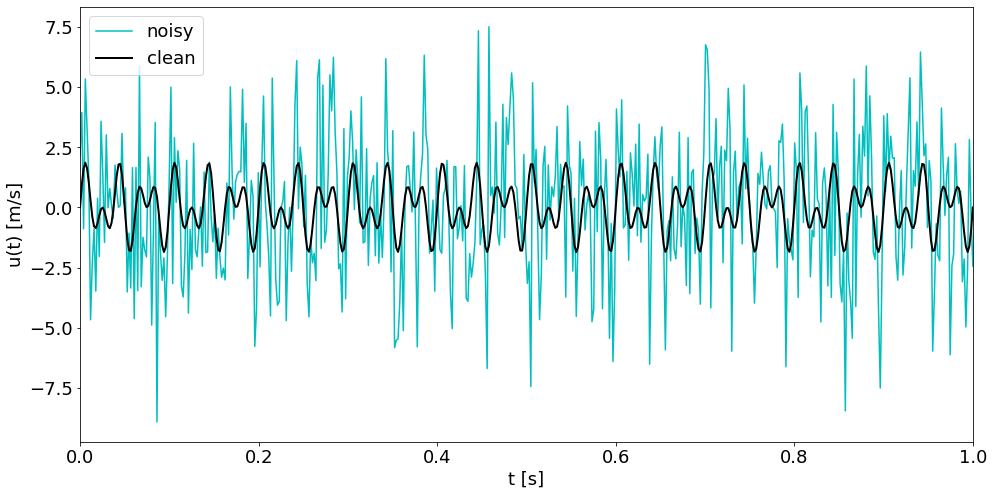

In [ ]:
N = 512 # data points
t = np.linspace(0, 1, N)  # time discretization vector of length N in (0,1)

u_clean = np.sin(2*np.pi*50*t) + np.sin(2*np.pi*30*t)  # superposition of two sine waves
u = u_clean + 2.5*np.random.randn(len(t))  # add Gaussian noise

plt.plot(t, u, 'c', lw=1.5, label='noisy')
plt.plot(t, u_clean, 'k', lw=2, label='clean')
plt.xlabel('t [s]')
plt.ylabel('u(t) [m/s]')
plt.xlim(0, 1)
plt.legend()

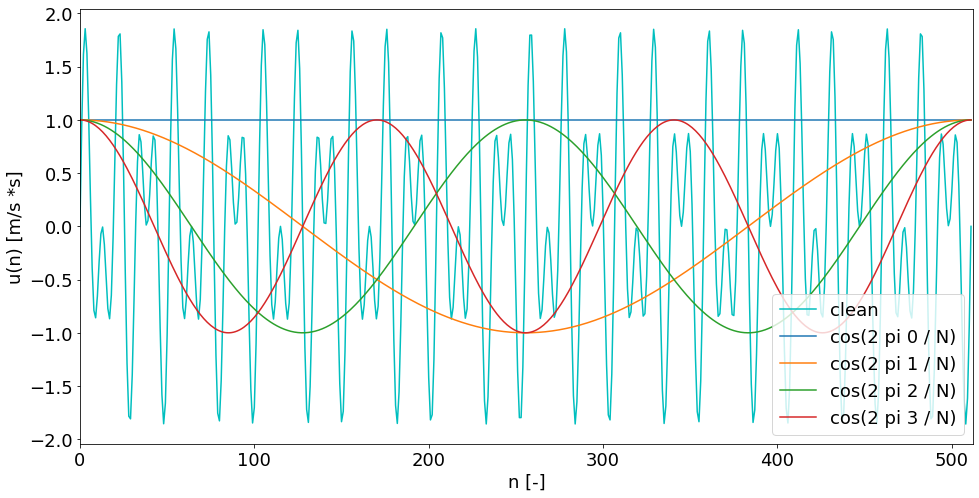

In [ ]:
n = np.arange(N)

plt.plot(n, u_clean, 'c', label='clean')
plt.plot(n, np.cos(2*np.pi*0*t), label='cos(2 pi 0 / N)')
plt.plot(n, np.cos(2*np.pi*1*t), label='cos(2 pi 1 / N)')
plt.plot(n, np.cos(2*np.pi*2*t), label='cos(2 pi 2 / N)')
plt.plot(n, np.cos(2*np.pi*3*t), label='cos(2 pi 3 / N)')
plt.xlabel('n [-]')
plt.ylabel('u(n) [m/s *s]')
plt.xlim(0, N)
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


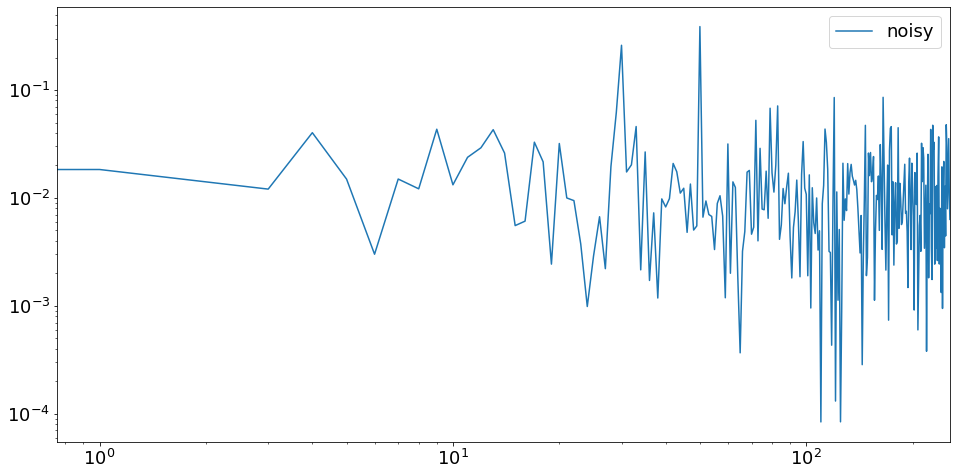

In [ ]:
u_hat = np.fft.fft(u, N) / N  # velocity fluctuations in Fourier space
PSD = u_hat * np.conj(u_hat)  # Power / Energy spectrum density, i.e. amount of energy per frequency
w = 1/(t[-1]-t[0]) * np.arange(N)  # frequency, i.e. x-axis in Fourier space
mask = np.arange(N//2)  # Consider only the results for frequencies smaller than the Nyquist frequency.

# plt.plot(w[mask], np.real(u_hat[mask]), label='noisy')
plt.loglog(w[mask], PSD[mask].real, label='noisy')
plt.xlim(w[mask][0], w[mask][-1])
plt.legend()


# 2D Spatial FFT

We use the library [JAX-CFD](https://github.com/google/jax-cfd) only to get a sampple of a 2D turbulent flow field, i.e. two 2D tensors corresponding to velocity in x and y directions. We then transform the x and y velocity fields at a fixed time using the spatial [2D FFT from numpy](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft2.html#numpy.fft.fft2).

In [ ]:
! pip install -U -q jax-cfd  # install jax-cfd
import jax_cfd.base as cfd

In [ ]:
def plots(U1, U2):
  plt.subplot(1, 2, 1)
  plt.imshow(U1.real)
  plt.colorbar()
  plt.subplot(1, 2, 2)
  plt.imshow(U2.real)
  plt.colorbar()

In [ ]:
# source: https://github.com/google/jax-cfd/blob/main/notebooks/demo.ipynb
size = 256
seed = 0
max_velocity = 2.0

# Define the physical dimensions of the simulation.
grid = cfd.grids.Grid((size, size), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))

# Construct a random initial velocity. The `filtered_velocity_field` function
# ensures that the initial velocity is divergence free and it filters out
# high frequency fluctuations.
v0 = cfd.initial_conditions.filtered_velocity_field(
    jax.random.PRNGKey(seed), grid, max_velocity)


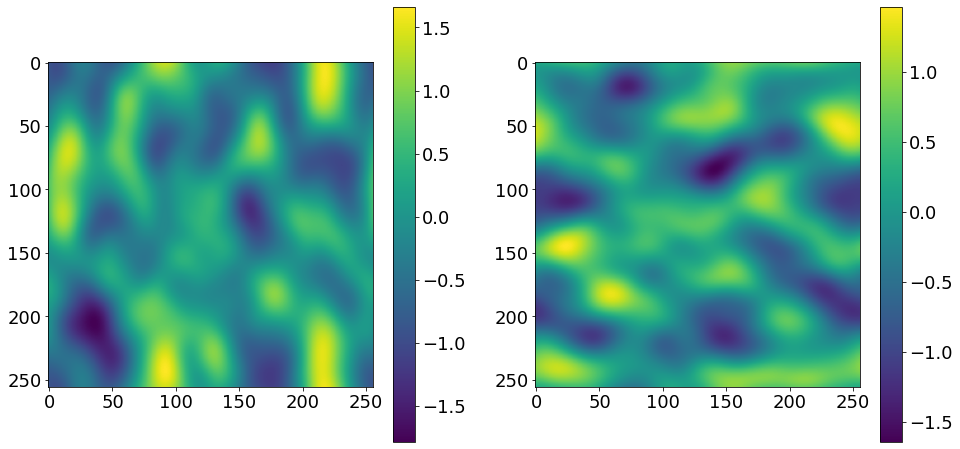

In [ ]:
u_x = np.asarray(v0[0].data)
u_y = np.asarray(v0[1].data)
plots(u_x, u_y)

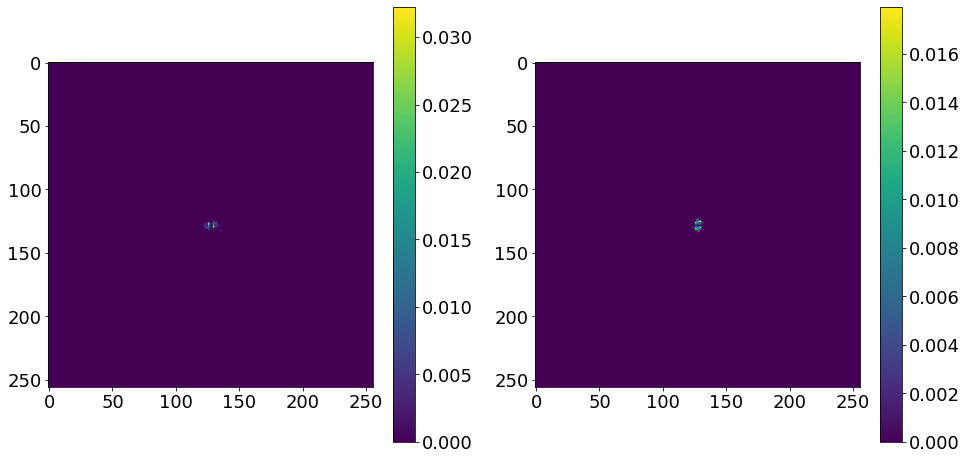

In [ ]:
# source: https://github.com/fanav/Energy_Spectrum
u_hat_x = np.fft.fft2(u_x)/u_x.size
u_hat_y = np.fft.fft2(u_y)/u_y.size

K_x = u_hat_x * np.conj(u_hat_x) # PSD in x direction
K_y = u_hat_y * np.conj(u_hat_y) # for complex number x it is true that: abs(x)**2=x*np.conj(x)

K_x = np.fft.fftshift(K_x)  # centering result
K_y = np.fft.fftshift(K_y)

plots(K_x.real, K_y.real)

In [ ]:
# integrate power spectrum in azymuthal direction, i.e. sum up all contributions
# at equal distance from the center

eps = 1e-30
box_radius = int(np.ceil(np.sqrt(size**2+size**2)/2.)+1) # half diagonal
centerx = int(size/2)
centery = int(size/2)

K_x_avsphr = np.zeros(box_radius,)+eps 
K_y_avsphr = np.zeros(box_radius,)+eps 

# azymuthal average
for i in range(size):
  for j in range(size):
    wn =  int(np.round(np.sqrt((i-centerx)**2+(j-centery)**2)))
    K_x_avsphr[wn] += K_x[i,j].real
    K_y_avsphr[wn] += K_y[i,j].real   

K_avsphr = 0.5*(K_x_avsphr + K_y_avsphr)

Real      Kmax    =  129
Spherical Kmax    =  183
mean TKE discrete  =  0.361428439617157
mean TKE sphere    =  0.3614284159795223


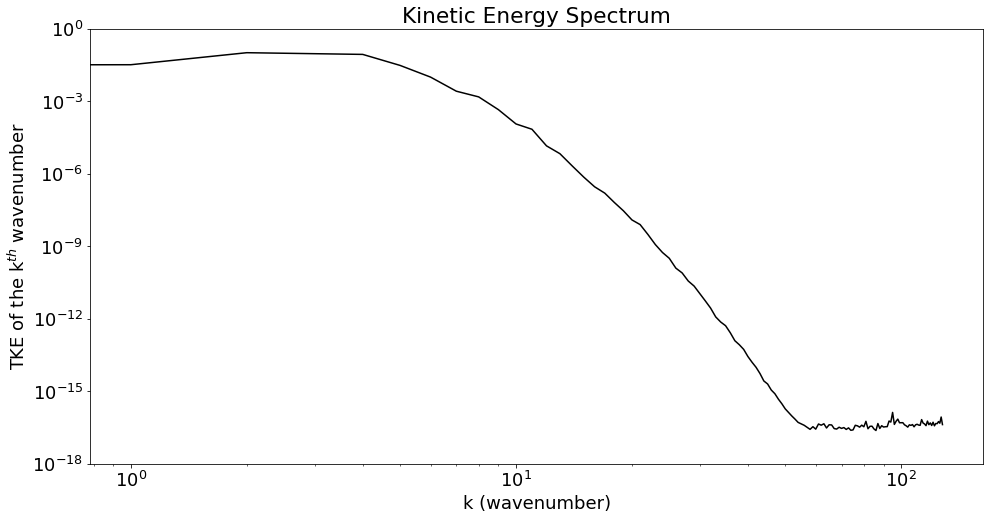

In [ ]:
fig = plt.figure()
plt.title("Kinetic Energy Spectrum")
plt.xlabel(r"k (wavenumber)")
plt.ylabel(r"TKE of the k$^{th}$ wavenumber")

# realsize is defined using the FFT for a real valued array `rfft`. Used to get 
# all frequencies up to Nyquist, i.e. left lalf of previous FFT.
realsize = len(np.fft.rfft(u_x[:,0])) 
plt.loglog(np.arange(0,realsize),((K_avsphr[0:realsize] )),'k')
# axes = plt.gca()
plt.ylim([10**-18,1])

print("Real      Kmax    = ",realsize)
print("Spherical Kmax    = ",len(K_avsphr))

total_TKE_discrete = np.sum(0.5*(u_x**2+u_y**2))/(size*1.0)**2  # as cross reference to see that our implementation is correct
total_TKE_sphere   = np.sum(K_avsphr)

print("mean TKE discrete  = ",total_TKE_discrete)
print("mean TKE sphere    = ",total_TKE_sphere)